# Mounting google drive

In [0]:
#pip install --upgrade gensim

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load modules

In [0]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from gensim.models import Word2Vec
import re
import unicodedata
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load and explore data

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Word2Vec /nips.csv')
df = df[df['Abstract'] != "Abstract Missing"]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4933 entries, 0 to 4932
Data columns (total 3 columns):
Year        4933 non-null int64
Title       4933 non-null object
Abstract    4933 non-null object
dtypes: int64(1), object(2)
memory usage: 115.7+ KB


In [0]:
text = df['Abstract']
text.head()

0    Up-propagation is an algorithm for inverting ...
1    We have constructed an inexpensive video based...
2    Non-negative matrix factorization (NMF) has pr...
3    Spike-triggered averaging techniques are effec...
4    We consider continuous state, continuous actio...
Name: Abstract, dtype: object

In [0]:
def print_text(index, Series):
    example = Series[Series.index == index].values[0]
    if len(example) > 0:
        print(example)
    else:
      print('Empty!')

In [0]:
print_text(1,text)

We have constructed an inexpensive video based motorized tracking system that learns to track a head. It uses real time graphical user inputs or an auxiliary infrared detector as supervisory signals to train a convolutional neural network. The inputs to the neural network consist of normalized luminance and chrominance images and motion information from frame differences. Subsampled images are also used to provide scale invariance. During the online training phases the neural network rapidly adjusts the input weights depending up on the reliability of the different channels in the surrounding environment. This quick adaptation allows the system to robustly track a head even when other objects are moving within a cluttered background.


In [0]:
corpus_init = ' '.join(list(text))
words_init = corpus_init.split()
n_words_init = len(words_init)
unique_words_init = sorted(list(set(words_init)))
n_unique_words_init = len(unique_words_init)
print("Total number of words before text preprocessing:", n_words_init)
print("Total number of unique words before text preprocessing: ", n_unique_words_init)
print(unique_words_init[:100])
print(unique_words_init[100:200])
print(unique_words_init[200:300])

Total number of words before text preprocessing: 732614
Total number of unique words before text preprocessing:  41882
['"', '"ALBO"', '"Air', '"Air\'\'', '"Answerer', '"DIRECT"', '"DUOL"', '"Expansion-Constrained', '"Generalized', '"Ghost', '"Graph', '"GuessWhat?!".', '"Hedge"', '"Hey', '"I', '"Ising\'\'', '"MNIST', '"Object', '"PixelGAN', '"Self-Expressiveness', '"Short-Dot"', '"TILT\'\'', '"Ugliness-in-Averageness"', '"What', '"additional', '"anti-Bayesian"', '"autotags")', '"averagers,"', '"batch"', '"best', '"body\'\'', '"body\'\',', '"building', '"bus', '"calibration', '"catalyst"', '"chill"', '"comparison', '"condition', '"context",', '"convergence', '"cooperative', '"correctness"', '"date"', '"deep', '"degrees', '"deltas",', '"denoise"', '"describing"', '"determinantal', '"disagreement', '"disappearance"', '"discriminating"', '"discriminative', '"early', '"edge', '"efficient"', '"em', '"equalized', '"exemplars"', '"expected', '"extended', '"external"', '"fair."', '"few-shot\'\'

# Text Preprocessing

In [0]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word != ',' or word != '.':
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

In [0]:
def clean_text(text):
  # noise removal
  text = re.sub(r'\bhttps?://\w+.+[^ ]\b', 'link', text) #replace url with "link"
  text = re.sub(r'[a-zA-Z0-9]*\.?github\.?[a-zA-Z0-9]*','github',text) #replace github links with "github"
  text = re.sub(r'\~\\cite\{[^}]*\}','',text) # remove cite in the format of "~\cite{DeSaOR16}"
  text = re.sub(r'\[[^]]*\]', '', text) # remove between square brackets
  text = re.sub(r'\([^)]*\)', '', text) # remove between parentheses
  text = re.sub(r'\{[^)]*\}', '', text) # remove between curly brackets
  
  # normalization
  text = text.lower() # convert to lowercase text
  
  text = re.sub(r'\-',' ', text) # seperate words like 'video-related'
  text = re.sub(r'[^a-zA-Z0-9\s\.\,]', '', text) # remove punctuation 
  
  text = re.sub(r'i\.?e\.?', ' ie ' , text) # replace 'i.e.' 
  text = re.sub(r'e\.?g\.?',' eg ', text)# replace 'i.e.' 
  text = re.sub(r'i\.?i\.?d\.?',' independent identically distributed ',text) #replace 'i.i.d.' or 'i.i.d'
  text = re.sub(r'd\.?c\.?',' dc ',text) #replace 'd.c.'
  text = re.sub(r'et\.?[ \t\n\r\f\v]*al[ \t\n\r\f\v]?\.?', ' et al', text) # replace "et. al." with "et al"
  text = re.sub(r'w\.?r\.?t\.?', ' wrt', text)
  text = re.sub(r'a\.?k\.?a\.?', ' aka ', text)
  text = re.sub(r'u\.?s\.?',' us', text)
  text = re.sub(r'd\.?s\.?',' ds', text)
  text = re.sub(r'a\.?s\.?',' as', text)
  text = re.sub(r'v\.?s\.?',' vs', text)
  text = re.sub(r'r\.?v\.?',' rv', text)
  text = re.sub(r'c\.?n\.?',' cn', text)
  text = re.sub(r'w\.h\.p\.', ' ', text)
  
  text = re.sub(r'[-+]?\d*\.?\d+', 'NUMBER', text) # replace numbers with "NUMBER"
  
  text = re.sub(r'\.{2,}', '', text) # remove '..','...'
  text = re.sub(r'\.', ' . ', text) # seperate '.' from text
  text = re.sub(r'\,' , ' , ', text) # seperate ',' from text
 
  text = ' '.join(remove_non_ascii(text.split())) # remove non-ascii words
  text = re.sub(r'[\w]*NUMBER[\w]*', 'NUMBER', text) # replace anyword containing "NUMBER" with "NUMBER"
  
  return text

In [0]:
text = text.apply(clean_text)

In [0]:
text_list = list(text)
corpus = ' '.join(text_list)
words = corpus.split()
n_words = len(words)
unique_words = sorted(list(set(words)))
n_unique_words = len(unique_words)
print("Total number of words:", n_words)
print("Total number of unique words: ", n_unique_words)
print(unique_words[:100])
print(unique_words[100:200])
print(unique_words[200:300])
print(unique_words[300:400])
print(unique_words[400:500])

Total number of words: 847564
Total number of unique words:  15059
[',', '.', 'NUMBER', 'a', 'aa', 'aaai', 'aalen', 'aaronson', 'ab', 'abandons', 'abbe', 'abc', 'abdominal', 'aberrant', 'abf', 'abilit', 'ability', 'abilityto', 'ablation', 'able', 'ables', 'abn', 'abnormal', 'abnormalit', 'abnormality', 'aboun', 'abound', 'about', 'above', 'abovethreshold', 'abp', 'abrupt', 'abscissa', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstain', 'abstaining', 'abstention', 'abstract', 'abstracted', 'abstraction', 'abstractions', 'abstractionthe', 'abstractive', 'abstracts', 'abundance', 'abundancy', 'abundant', 'ac', 'academic', 'academics', 'accelerate', 'accelerated', 'accelerates', 'accelerating', 'acceleration', 'accelerators', 'accelerometers', 'accentuated', 'accept', 'acceptability', 'acceptable', 'acceptably', 'acceptance', 'accepted', 'accepts', 'access', 'accessed', 'accesses', 'accessibility', 'accessible', 'accessing', 'accident'

In [0]:
sent_text = sent_tokenize(corpus)
sent_text[20010:20018]

['recent work h as highlighted the power law propert ie s of brain signals however , there remains a lack of metho ds to specifically quantify short vs long time range brain connections .',
 'in this paper , using detrended partial cross correlation analysis , we propose a novel functional connectivity me asure to delineate brain interactions at multiple time scales , while controlling for covariates .',
 'we use a rich simulated fmri dat aset to validate the proposed method , and apply it to a real fmri dat aset in a cocaine dependence prediction t ask .',
 'we show that , compared to extant metho ds , the dpcca b ased approach not only distinguishes short and long memory functional connectivity but also improves feature extraction and enhances cl assification accuracy .',
 'together , this paper contributes broadly to new computational methodolog ie s in understanding neural information processing .',
 'image captioning , a popular topic in computer vision , h as ach ie ved substanti

In [0]:
sentences = [] # list of lists
max_sent_length = 0
min_sent_length = float('Inf')
for sent in sent_text:
  sent_words = word_tokenize(sent)
    
  n_words = len(sent_words)
  
  # remove sentences with less than or equal to 3 words
  if n_words > 3:
    sentences.append(sent_words)
    if max_sent_length < n_words:
       max_sent_length = n_words
    if min_sent_length > n_words:
       min_sent_length = n_words

n_sentences = len(sentences)

print("Total number of sentences: ", n_sentences)
print("Maximum length of sentences: ", max_sent_length)
print("Minimus length of sentences: ",min_sent_length)
print(sentences[:5])

Total number of sentences:  29972
Maximum length of sentences:  149
Minimus length of sentences:  4
[['up', 'propagation', 'is', 'an', 'algorithm', 'for', 'inverting', 'and', 'learning', 'neural', 'network', 'generative', 'models', 'sensory', 'input', 'is', 'processed', 'by', 'inverting', 'a', 'model', 'that', 'generates', 'patterns', 'from', 'hidden', 'variables', 'using', 'topdown', 'connections', 'the', 'inversion', 'process', 'is', 'iterative', 'utilizing', 'a', 'n', 'eg', 'ative', 'feedback', 'loop', 'that', 'depen', 'ds', 'on', 'an', 'error', 'signal', 'propagated', 'by', 'bottomup', 'connections', 'the', 'error', 'signal', 'is', 'also', 'used', 'to', 'learn', 'the', 'generative', 'model', 'from', 'examples', 'the', 'algorithm', 'is', 'benchmarked', 'against', 'principal', 'component', 'analysis', 'in', 'experiments', 'on', 'images', 'of', 'handwritten', 'digits', '.'], ['we', 'have', 'constructed', 'an', 'inexpensive', 'video', 'b', 'ased', 'motorized', 'tracking', 'system', 'th

In [0]:
# for i, sent in enumerate(sentences):
#   if len(sent) <= 3:
#     print(i, sent)

# Genism word2vec Modeling

# Training

In [0]:
model = Word2Vec(sentences, 
                 min_count = 5, 
                 size= 512, # number of dimensions of the embedding
                 workers = 3, 
                 window = 5, 
                 sg = 1) # CBOW (0), skip gram (1)

## Evaluation

In [0]:
# Model
print(model)

Word2Vec(vocab=5980, size=512, alpha=0.025)


In [0]:
# Vocabulary
words = list(model.wv.vocab)
print(words[:10])
print(words[10:20])

['up', 'propagation', 'is', 'an', 'algorithm', 'for', 'inverting', 'and', 'learning', 'neural']
['network', 'generative', 'models', 'sensory', 'input', 'processed', 'by', 'a', 'model', 'that']


In [0]:
model.wv.most_similar('neural', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('recurrent', 0.7344039082527161),
 ('convolutional', 0.675775945186615),
 ('cnns', 0.6747896671295166),
 ('neuronal', 0.6554031372070312),
 ('feedforward', 0.6524607539176941)]

# Visualizations

In [0]:
# Select words for visualizations
words_select = ['up', 'propagation', 'algorithm', 'neural']

#Create similar words vectors
def similar_words_embeddings(words):
  embedding_clusters = []
  word_clusters = []
  for word in words:
      embeddings_similar = []
      words_similar = []
      for similar_word, _ in model.wv.most_similar(word, topn=30):
          words_similar.append(similar_word)
          embeddings_similar.append(model[similar_word])
      embedding_clusters.append(embeddings_similar)
      word_clusters.append(words_similar)
  return embedding_clusters, word_clusters

embedding_clusters, word_clusters = similar_words_embeddings(words_select)

In [0]:
# t-SNE
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=10)
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

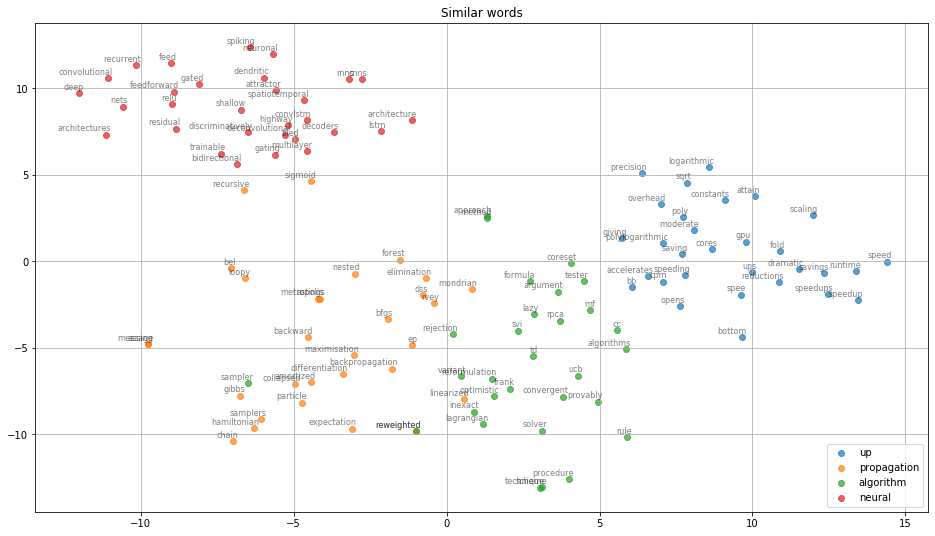

In [0]:
# Plot
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words('Similar words', words_select, embeddings_2d, word_clusters, 0.7,)

# Save word embeddings

In [0]:
# save model
#model.save('model.bin') #binary format